# Exercise
Objective: Design a model predictive controller for an overhead crane with a pendulum mass. Meet specific control objectives by tuning the controller and using the state space model of the crane system. Simulate and optimize the pendulum system with an adjustable overhead cart. Estimated time: 2 hours.

[link](https://apmonitor.com/do/index.php/Main/ControlTypes_)

apm 10.32.114.116_gk_model1 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            8
   Intermediates:            1
   Connections  :            0
   Equations    :           10
   Residuals    :            9
 
 Number of state variables:            891
 Number of total equations: -          792
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             99
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

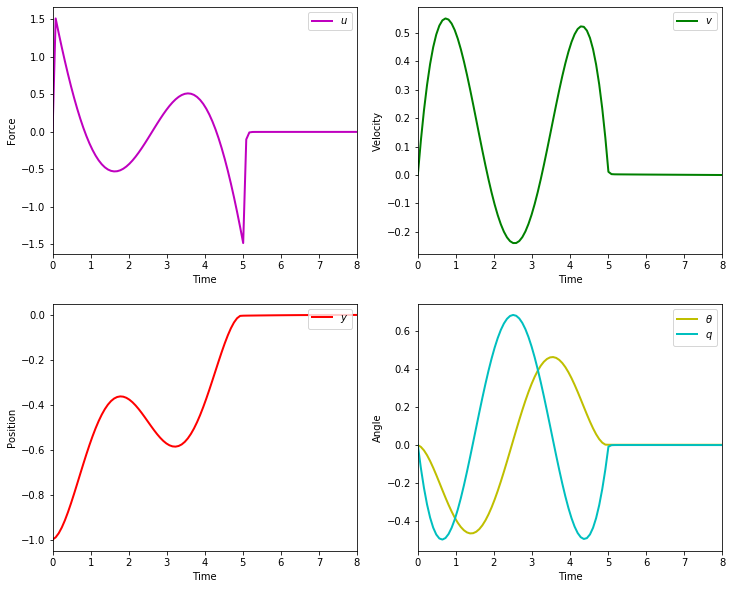

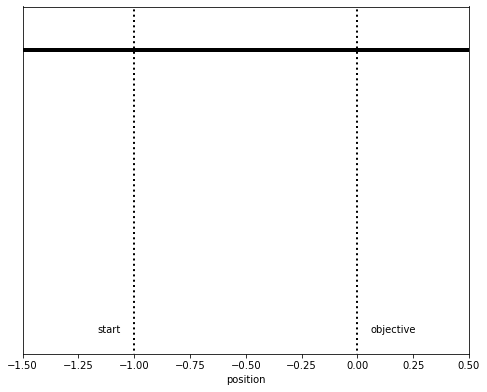

In [2]:
import matplotlib.animation as animation
import numpy as np
from gekko import GEKKO
# requires ffmpeg to save mp4 file
#  available from https://ffmpeg.zeranoe.com/builds/
#  add ffmpeg.exe to path such as C:\ffmpeg\bin\ in
#  environment variables

#Defining a model
m = GEKKO()

#################################
#Weight of item
m2 = 5
#################################

#Defining the time, we will go beyond the 6.2s
#to check if the objective was achieved
m.time = np.linspace(0,8,100)

#Parameters
m1a = m.Param(value=10)
m2a = m.Param(value=m2)
final = np.zeros(len(m.time))
for i in range(len(m.time)):
    if m.time[i] < 5:
        final[i] = 0
    else:
        final[i] = 1
final = m.Param(value=final)

#MV
ua = m.Var(value=0)

#State Variables
theta_a = m.Var(value=0)
qa = m.Var(value=0)
ya = m.Var(value=-1)
va = m.Var(value=0)

#Intermediates
epsilon = m.Intermediate(m2a/(m1a+m2a))

#Defining the State Space Model
m.Equation(ya.dt() == va)
m.Equation(va.dt() == epsilon*theta_a + ua)
m.Equation(theta_a.dt() == qa)
m.Equation(qa.dt() == -theta_a -ua)

#Definine the Objectives
#Make all the state variables be zero at time >= 6.2
m.Obj(final*ya**2)
m.Obj(final*va**2)
m.Obj(final*theta_a**2)
m.Obj(final*qa**2)
#Try to minimize change of MV over all horizon
m.Obj(0.001*ua**2)

m.options.IMODE = 6 #MPC
m.solve() #(disp=False)

#Plotting the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))

plt.subplot(221)
plt.plot(m.time,ua.value,'m',lw=2)
plt.legend([r'$u$'],loc=1)
plt.ylabel('Force')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(222)
plt.plot(m.time,va.value,'g',lw=2)
plt.legend([r'$v$'],loc=1)
plt.ylabel('Velocity')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(223)
plt.plot(m.time,ya.value,'r',lw=2)
plt.legend([r'$y$'],loc=1)
plt.ylabel('Position')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.subplot(224)
plt.plot(m.time,theta_a.value,'y',lw=2)
plt.plot(m.time,qa.value,'c',lw=2)
plt.legend([r'$\theta$',r'$q$'],loc=1)
plt.ylabel('Angle')
plt.xlabel('Time')
plt.xlim(m.time[0],m.time[-1])

plt.rcParams['animation.html'] = 'html5'

x1 = ya.value
y1 = np.zeros(len(m.time))

#suppose that l = 1
x2 = 1*np.sin(theta_a.value)+x1
x2b = 1.05*np.sin(theta_a.value)+x1
y2 = -1*np.cos(theta_a.value)+y1
y2b = -1.05*np.cos(theta_a.value)+y1

fig = plt.figure(figsize=(8,6.4))
ax = fig.add_subplot(111,autoscale_on=False,\
                     xlim=(-1.5,0.5),ylim=(-1.2,0.4))
ax.set_xlabel('position')
ax.get_yaxis().set_visible(False)

crane_rail, = ax.plot([-1.5,0.5],[0.2,0.2],'k-',lw=4)
start, = ax.plot([-1,-1],[-1.5,1],'k:',lw=2)
objective, = ax.plot([0,0],[-1.5,1],'k:',lw=2)
mass1, = ax.plot([],[],linestyle='None',marker='s',\
                 markersize=40,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
mass2, = ax.plot([],[],linestyle='None',marker='o',\
                 markersize=20,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
line, = ax.plot([],[],'o-',color='orange',lw=4,\
                markersize=6,markeredgecolor='k',\
                markerfacecolor='k')
time_template = 'time = %.1fs'
time_text = ax.text(0.05,0.9,'',transform=ax.transAxes)
start_text = ax.text(-1.06,-1.1,'start',ha='right')
end_text = ax.text(0.06,-1.1,'objective',ha='left')

def init():
    mass1.set_data([],[])
    mass2.set_data([],[])
    line.set_data([],[])
    time_text.set_text('')
    return line, mass1, mass2, time_text

def animate(i):
    mass1.set_data([x1[i]],[y1[i]+0.1])
    mass2.set_data([x2b[i]],[y2b[i]])
    line.set_data([x1[i],x2[i]],[y1[i],y2[i]])
    time_text.set_text(time_template % m.time[i])
    return line, mass1, mass2, time_text

ani_a = animation.FuncAnimation(fig, animate, \
         np.arange(1,len(m.time)), \
         interval=40,blit=False,init_func=init)

ani_a.save('Pendulum_Control.mp4',fps=30)

plt.show()